In [8]:
import warnings
warnings.filterwarnings(
    "ignore",
    category=UserWarning,
    message=".*FigureCanvasAgg is non-interactive.*"
)
import os
os.environ["NIXTLA_ID_AS_COL"] = "true"
import numpy as np
np.set_printoptions(suppress=True)
np.random.seed(1)
import random
random.seed(1)
import pandas as pd
pd.set_option("max_colwidth", 100)
pd.set_option("display.precision", 3)
from utilsforecast.plotting import plot_series as plot_series_utils
import seaborn as sns
sns.set_style("whitegrid")
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.rcParams.update({
    "figure.figsize": (8, 5),
    "figure.dpi": 100,
    "savefig.dpi": 300,
    "figure.constrained_layout.use": True,
    "axes.titlesize": 12,
    "axes.labelsize": 10,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "legend.fontsize": 9,
    "legend.title_fontsize": 10,
})
import matplotlib as mpl
from cycler import cycler
mpl.rcParams['axes.prop_cycle'] = cycler(color=["#000000", "#000000"])
from fpppy.utils import plot_series

In [9]:
from IPython.display import Image
from typing import Optional
from utilsforecast.losses import rmse, mae, smape
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import kpss
from statsforecast.models import AutoETS
from statsforecast.arima import ndiffs, nsdiffs

In [30]:
def gafa_stock():
    df = pd.read_csv('../data/gafa_stock.csv')
    df['date'] = pd.to_datetime(df['ds'])
    df = df.set_index(df['date']).sort_index()
    df.drop(['date','ds'], axis = 'columns', inplace = True)
    return df 

df = gafa_stock()
google = df.query(
  "unique_id == 'GOOG_Close' and index.dt.year == 2015"
).reset_index()

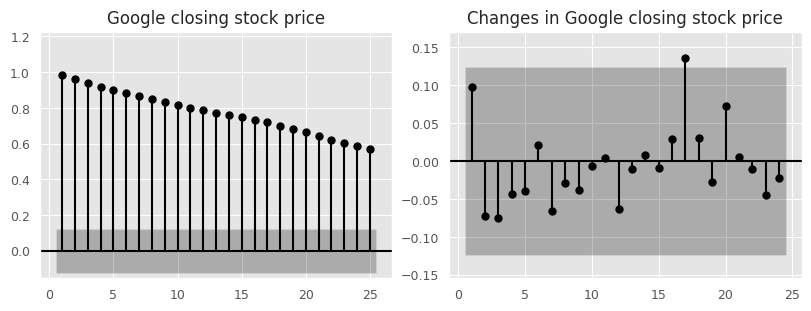

In [31]:
fig = plt.figure(figsize = (8, 3))
gs = fig.add_gridspec(1, 2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

plot_acf(
  google["y"], ax=ax1, zero=False,
  title="Google closing stock price",
  bartlett_confint=False, auto_ylims=True
)
plot_acf(
  google["y"].diff()[1:],
  ax=ax2, zero=False,
  title="Changes in Google closing stock price",
  bartlett_confint=False, auto_ylims=True
)
plt.show()

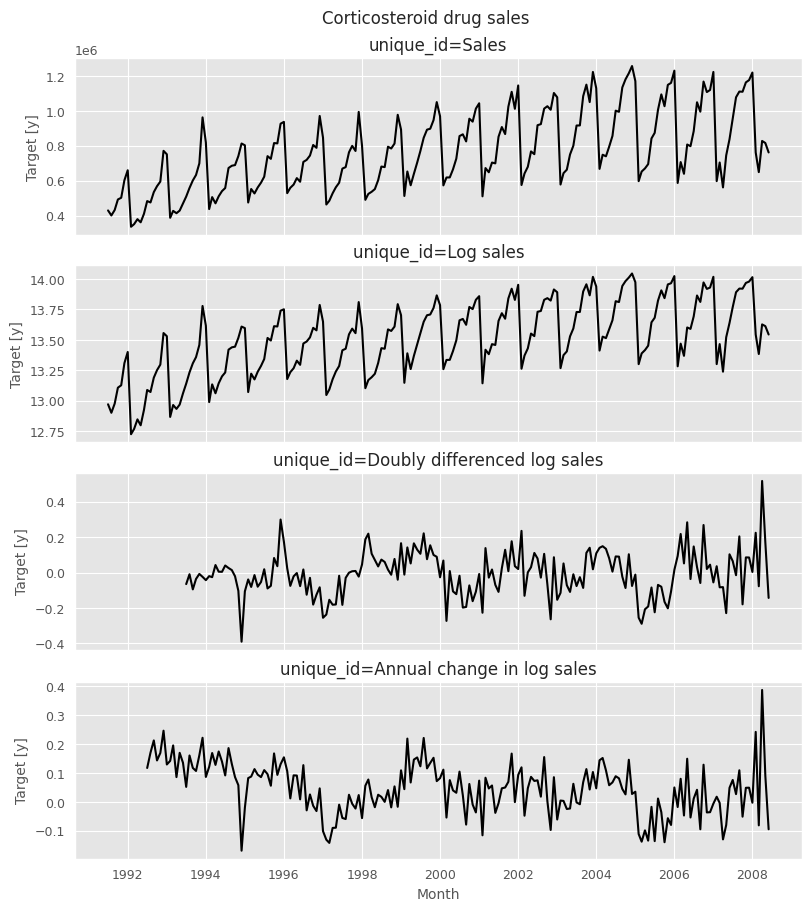

In [33]:
pbs = pd.read_csv("../data/PBS_unparsed.csv", parse_dates=["Month"])
pbs = pbs.rename(columns={"Month": "ds"})
pbs = pbs.query("ATC2 == 'H02'").reset_index(drop=True)
pbs = pbs.groupby(["ds"])["Cost"].sum().reset_index()
pbs = pbs.rename(columns={"Cost": "Sales"})
pbs["Log sales"] = np.log(pbs["Sales"])
pbs["Annual change in log sales"] = pbs["Log sales"].diff(periods=12)
pbs["Doubly differenced log sales"] = pbs["Annual change in log sales"].diff(periods=12)

pbs = pbs.set_index(["ds"]).stack().reset_index()
pbs = pbs.rename(columns={"level_1": "unique_id", 0: "y"})
pbs = pbs.sort_values(by=["unique_id", "ds"], ascending=[False, True]).reset_index(
  drop=True
)

_, axes = plt.subplots(nrows=4, ncols=1, figsize=(8, 9), sharex=True)
fig = plot_series_utils(pbs, ax=axes)
for ax in fig.axes:
  ax.tick_params(axis="both")
  if ax.get_legend():
    ax.get_legend().remove()
  for label in ax.get_xticklabels():
    label.set_rotation(0)
fig.legends = []
ax.set_xlabel("Month")
fig.suptitle("Corticosteroid drug sales", x=0.525)
fig

In [34]:
goog_kpss_stat, goog_kpss_pvalue, _, _ = kpss(google["y"], nlags = 5)
print(f"kpss_stat: {goog_kpss_stat:.3f}")
print(f"kpss_pvalue: {goog_kpss_pvalue:.2f}")

kpss_stat: 3.561
kpss_pvalue: 0.01


/tmp/ipykernel_273518/3069178439.py:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  goog_kpss_stat, goog_kpss_pvalue, _, _ = kpss(google["y"], nlags = 5)


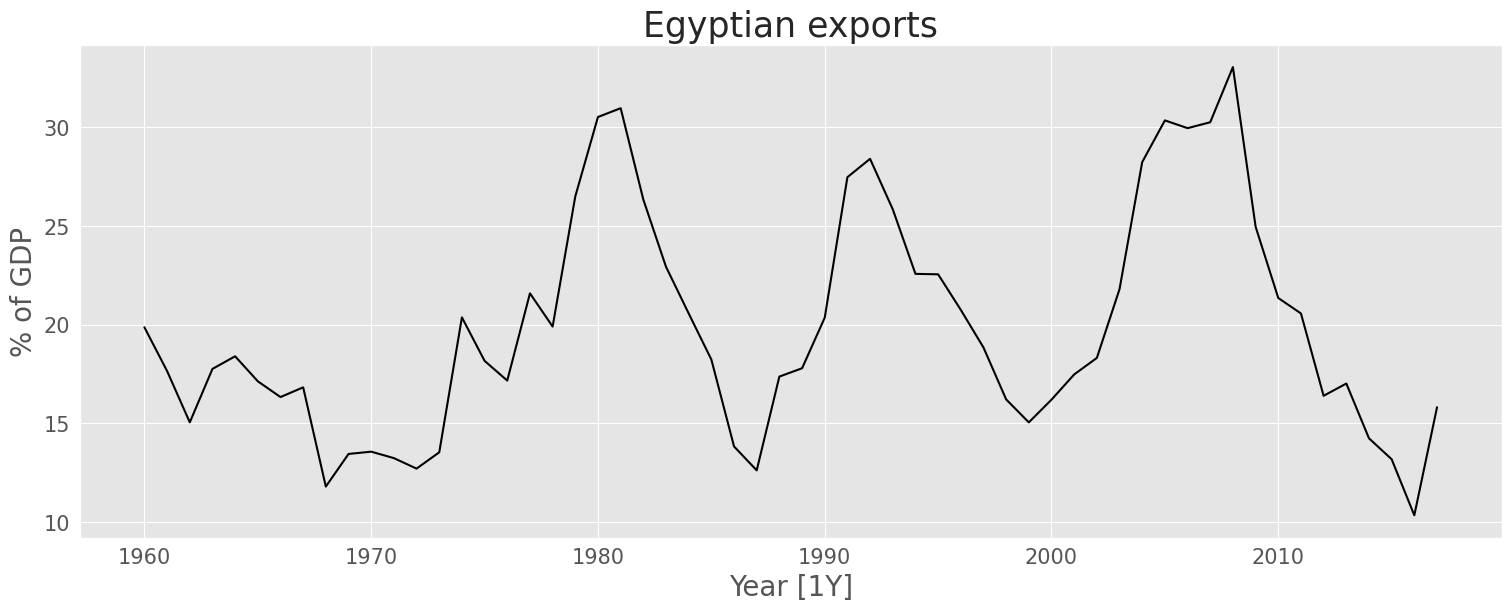

In [35]:
global_economy = pd.read_csv("../data/global_economy.csv", parse_dates=[2])
global_economy = global_economy.rename(columns={"Exports": "y"})
egyptian_economy = \
  global_economy.query("Code == 'EGY'").reset_index(drop=True)

plot_series(egyptian_economy, xlabel="Year [1Y]", ylabel="% of GDP", 
  title="Egyptian exports")

In [36]:
# selecting a non-seasonal ARIMA model for the egyptian exports time series 
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
from statsforecast.arima import ARIMASummary
from copy import deepcopy

models = [AutoARIMA(allowmean=True)]
sf = StatsForecast(models=models, freq="A", n_jobs=-1)
sf.fit(df=egyptian_economy[["ds", "y", "unique_id"]])

print(ARIMASummary(sf.fitted_[0, 0].model_))
coefs = deepcopy(sf.fitted_[0, 0].model_['coef'])
coefs["mean"] = coefs.pop("intercept")
coefs = {k: round(v, 3) for k, v in coefs.items()}
print(f"Coefficients: {coefs}")
print(f"sigma^2     : {sf.fitted_[0, 0].model_['sigma2']:.2f}")
print(f"loglik      : {sf.fitted_[0, 0].model_['loglik']:.2f}")
print(f"aic         : {sf.fitted_[0, 0].model_['aic']:.2f}")
print(f"aicc        : {sf.fitted_[0, 0].model_['aicc']:.2f}")
print(f"bic         : {sf.fitted_[0, 0].model_['bic']:.2f}")

ARIMA(2,0,1) with non-zero mean
Coefficients: {'ar1': 1.676, 'ar2': -0.803, 'ma1': -0.69, 'mean': 20.179}
sigma^2     : 8.05
loglik      : -141.57
aic         : 293.13
aicc        : 294.29
bic         : 303.43


/home/rishabh/miniconda3/envs/ts-env/lib/python3.11/site-packages/utilsforecast/processing.py:378: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/home/rishabh/miniconda3/envs/ts-env/lib/python3.11/site-packages/utilsforecast/processing.py:434: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  freq = pd.tseries.frequencies.to_offset(freq)


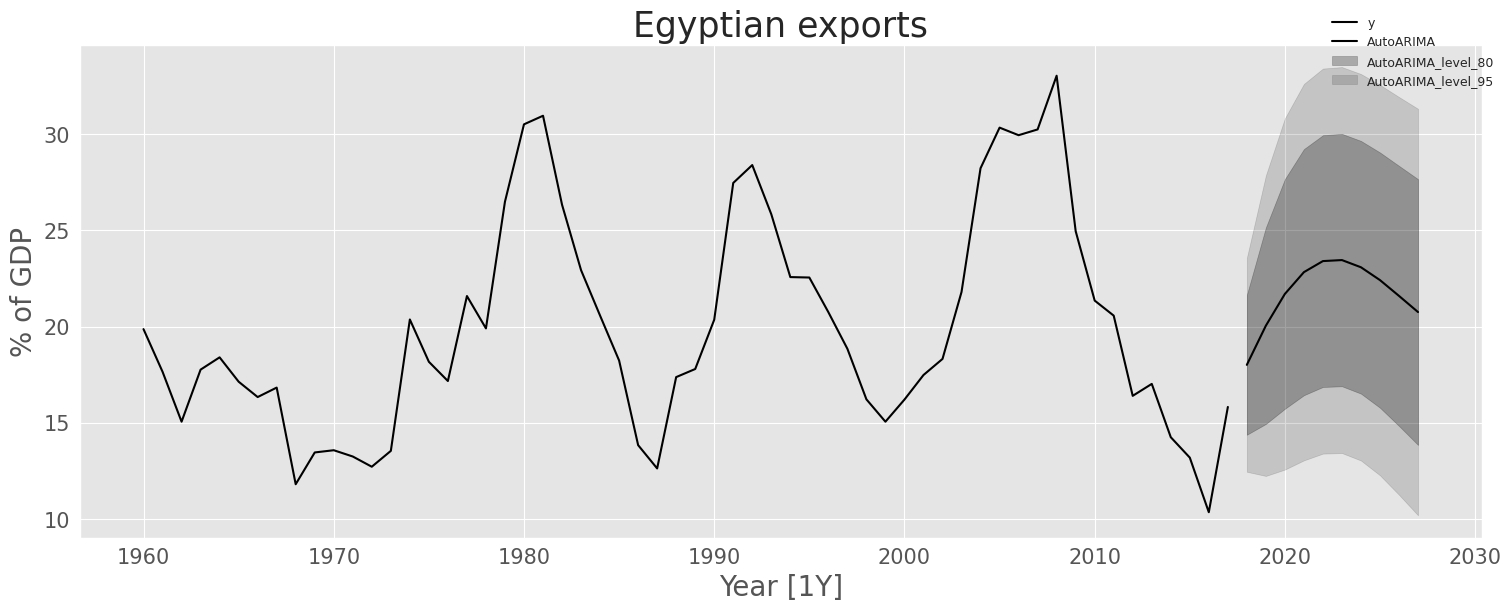

In [37]:
levels = [80, 95]
forecasts = sf.predict(h=10, level=levels)
plot_series(
  df=egyptian_economy[["ds", "y", "unique_id"]], 
  forecasts_df=forecasts, level=levels,
  xlabel="Year [1Y]", ylabel="% of GDP", title="Egyptian exports", 
  rm_legend=False,
)